# Poisson's equation

In [17]:
# Import libraries.
from matplotlib import pyplot, cm
from mpl_toolkits import mplot3d
import numpy

%matplotlib inline

In [18]:
# Update default font family and size for Matplotlib figures.
pyplot.rc('font', family='serif', size=16)

## Problem setup

Let's consider the following Poisson equation:

$$
\nabla^2 p = -2 \left( \frac{\pi}{2} \right)^2 \sin \left( \pi \frac{x}{L_x} \right) \cos \left( \pi \frac{y}{L_y} \right)
$$

in the domain $\Omega = \left[ 0, 1 \right] \times \left[ -0.5, 0.5 \right]$ with $L_x = L_y = 1$.

Let's use a Dirichlet condition $u = 0$ on all boundaries and $u = 0$ as our initial guess.

## Analytical solution

$$
p \left( x, y \right) = \sin \left( \pi \frac{x}{L_x} \right) \cos \left( \pi \frac{y}{L_y} \right)
$$

In [19]:
def poisson_solution(x, y, Lx, Ly):
    """Compute the analytical solution.

    Parameters
    ----------
    x : numpy.ndarray
        Coordinates in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Coordinates in the y direction as a 1D array of floats.
    Lx : float
        Length of the domain in the x direction.
    Ly : float
        Length of the domain in the y direction.

    Returns
    -------
    p : numpy.ndarray
        The analytical solution as a 2D array of floats.

    """
    X, Y = numpy.meshgrid(x, y)
    p = numpy.sin(numpy.pi * X / Lx) * numpy.cos(numpy.pi * Y / Ly)
    
    return p

In [20]:
def plot_3d(x, y, p, label='$z$', elev=30.0, azim=45.0):
    """Create a 3D surface plot of the scalar field `p`.

    Parameters
    ----------
    x : numpy.ndarray
        Gridline locations in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Gridline locations in the y direction as a 1D array of floats.
    p : numpy.ndarray
        Scalar field to plot as a 2D array of floats.
    label : string, optional
        Axis label to use in the third direction; default: 'z'.
    elev : float, optional
        Elevation angle in the z plane; default: 30.0.
    azim : float, optional
        Azimuth angle in the x,y plane; default: 45.0.

    """
    fig = pyplot.figure(figsize=(8.0, 6.0))
    ax = mplot3d.Axes3D(fig)
    ax.set_xlabel('$x$')
    ax.set_ylabel('$y$')
    ax.set_zlabel(label)
    X, Y = numpy.meshgrid(x, y)
    ax.plot_surface(X, Y, p, cmap=cm.viridis)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylim(y[0], y[-1])
    ax.view_init(elev=elev, azim=azim)

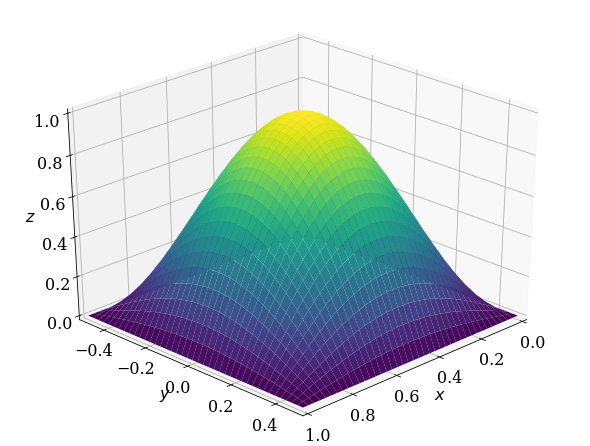

In [21]:
# Set parameters.
Lx, Ly = 1.0, 1.0  # lengths of the domain
nx, ny = 41, 41  # number of points along each direction
dx, dy = Lx / (nx - 1), Ly / (ny - 1)  # grid-spacing sizes

# Set the grid-point coordinates.
x = numpy.linspace(0.0, Lx, num=nx)
y = numpy.linspace(-0.5 * Ly, 0.5 * Ly, num=ny)

p_exact = poisson_solution(x, y, Lx, Ly)
plot_3d(x, y, p_exact)


## Initial solution

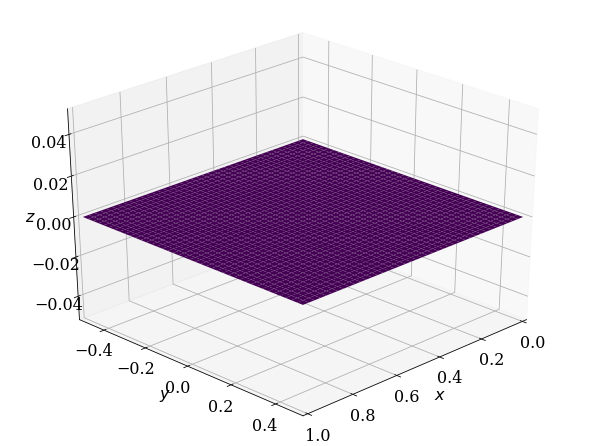

In [22]:
p0 = numpy.zeros((ny, nx))

plot_3d(x, y, p0)


## Source term

$$
\nabla^2 p = b
$$

with

$$
b = -2 \left( \frac{\pi}{2} \right)^2 \sin \left( \pi \frac{x}{L_x} \right) \cos \left( \pi \frac{y}{L_y} \right)
$$

In [31]:
def poisson_source(x, y, Lx, Ly):
    """Compute the Poisson source term.
    
    Parameters
    ----------
    x : numpy.ndarray
        Coordinates in the x direction as a 1D array of floats.
    y : numpy.ndarray
        Coordinates in the x direction as a 1D array of floats.
    Lx : float
        Domain length in the x direction.
    Ly : float
        Domain length in the y direction.
    
    Returns
    -------
    b : numpy.ndarray
        The forcing term as a 2D array of floats.

    """
    X, Y = numpy.meshgrid(x, y)
    b = (-2.0 * numpy.pi / Lx * numpy.pi / Ly *
         numpy.sin(numpy.pi * X / Lx) *
         numpy.cos(numpy.pi * Y / Ly))
    
    return b

In [32]:

#Compute the source term.
b = poisson_source(x, y, Lx, Ly)


## Jacobi method

$$
u_{i, j}^{k+1} = \frac{1}{4} \left( u_{i, j-1}^k + u_{i-1, j}^k + u_{i+1, j}^k + u_{i, j+1}^k - b_{i, j} \right)
$$

In [37]:
def poisson_2d_jacobi(p0, b, delta, maxiter=20000, rtol=1e-8):
    """Solve the 2D Poisson equation using Jacobi method.

    Parameters
    ----------
    p0 : numpy.ndarray
        The initial solution as a 2D array of floats.
    b : numpy.ndarray
        The forcing term as a 2D array of floats.
    delta : float
        Grid spacing in the x and y directions.
    maxiter : integer, optional
        Maximum number of iterations to perform; default: 20000.
    rtol : float, optional
        Relative tolerance for convergence; default: 1e-8.

    Returns
    -------
    p : numpy.ndarray
        The solution after relaxation as a 2D array of floats.
    ite : integer
        The number of iterations performed.
    conv : list
        The convergence history as a list of floats.

    """
    p = p0.copy()  # create copy to not overwrite initial guess
    conv = []  # convergence history
    diff = rtol + 1.0  # initialize residual to "high" value
    ite = 0  # initialize iteration index
    while diff > rtol and ite < maxiter:
        
        pn = p.copy()  # store the solution at previous iteration
        p[1:-1, 1:-1] = 0.25 * (pn[:-2, 1:-1] + pn[2:, 1:-2] +
                                pn[1:-1, :-2] + pn[1:-1, 2:] -
                                delta**2 * b[1:-1, 1:-1])
        
        #l2 norm of the difference
        diff = numpy.linalg.norm(p - pn) / numpy.linalg.norm(pn)
        
        conv.append(diff)
        
        ite += 1  # update the iteration index
        
    return p, ite, conv

In [38]:
# Compute the solution using Jacobi relaxation method.
p, ites, conv = poisson_2d_jacobi(p0, b, dx, dy, rtol=2e-7)
print('Jacobi relaxation: {} iterations '.format(ites) +
      'to reach a relative difference of {}'.format(conv[-1]))

# Plot the solution.
plot_3d(x, y, p)

ValueError: operands could not be broadcast together with shapes (39,39) (39,38) 

In [ ]:
###
# To do: Plot (semilog) the convergence history.
###


## Spatial convergence analysis

In [ ]:
# List of grid-spacing sizes to investigate.
dx_vals = [0.1, 0.05, 0.025, 0.0125]

# Empty list to store the error on each grid.
errors = []

for dx in dx_vals:
    ###
    # To do: Re-create the space grid.
    # To do: Re-set the initial guess.
    # To do: Re-compute the source term.
    # To do: Relax the solution with Jacobi.
    # To do: Compute the analytical solution.
    # To do: Compute and append the relative L2 error to `errors`.
    ###
    

In [ ]:
###
# To do: Plot (loglog) the error versus the grid-spacing size.
# Question: What's the order of convergence?
###
